# Analysis of iceberg distribution in Greenland fjord


    GEOG528: Fall 2020,
    Siddharth Shankar,
    Department of Geology,
    University of Kansas


# Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import matplotlib as mpl
import mpld3

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)
import contextily as ctx


In [3]:
%load_ext sql
%sql postgresql://
%config SqlMagic.autopandas=True


In [4]:
import ipypostgis
%load_ext ipypostgis

In [5]:
import pandas as pd
import rpy2
%matplotlib inline
%reload_ext rpy2.ipython

In [6]:
# make PostGIS commands available to this notebook.
path = %env PATH
pg_path = '/usr/lib/postgresql/11/bin/:/usr/lib/postgresql/12/bin/'
if pg_path not in path: path = f'{path}:{pg_path}'
%env PATH=$path

env: PATH=/opt/tljh/user/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin:/usr/lib/postgresql/11/bin/:/usr/lib/postgresql/12/bin/


# Objective

__The goal of this project is to analyze iceberg distribution in Sermilik Fjord, South East Greenland. Through this project I want to understand, how the calving processes are impacting Sermilik Fjord (one of the fastest moving glaciers in Greenland) using iceberg distribution.__

__In order to improve the understanding, I will need to perform the following tasks:__

1. Visualize iceberg distribution.
2. Determine the frequency size distribution of icebergs in Sermilik Fjord.
3. Calculate percentage ice-cover within 2km x 2km grid cells in Sermilik Fjord.

# Data Preparation

## List of tables in the project
1. __iceberg_dist:__ Original iceberg table that houses the iceberg data
2. __grid_Sermilik:__ A grid table that houses 2km x 2km polygon grid cells in Sermilik Fjord
3. __overlap_pt_grid:__ A table that captures the point table __(iceberg_dist)__ intersection with grid polygon table __(grid_Sermilik)__
4. __overlap_pt_grid_sum:__ Table that sums areas of all points that are within a grid cell
5. __overlap_pt_grid_percent:__ Table that calculates and holds ice cover percentage per grid cell


## Creating new TABLE called  iceberg_dist

In [7]:
%%sql
DROP TABLE IF EXISTS iceberg_dist; 
CREATE TABLE iceberg_dist (
  id SERIAL,
  Area_sqm decimal,
  x decimal,
  y decimal,
  totalArea decimal,
  PRIMARY KEY (id)
)

 * postgresql://
Done.
Done.


""


## Copying all the .csv data from ./data directory

In [8]:
!psql -c "\COPY iceberg_dist FROM ./data/S1A_IW_GRDH_1SSH_20160114T085511_20160114T085536_009488_00DC4E_3DA0.tif.csv WITH CSV HEADER;"

COPY 15483


### Viewing the iceberg_dist TABLE after copying all the csv

In [9]:
%%sql
select * from iceberg_dist;

 * postgresql://
15483 rows affected.


,id,area_sqm,x,y,totalarea
0,1,1100,334165.16864305234,-2586242.8126422013,None
1,2,1000,334102.532279416,-2586287.176278565,None
2,3,1100,334526.07773396146,-2586311.903551292,None
3,4,400,334296.532279416,-2586374.176278565,None
4,5,500,333993.532279416,-2586383.176278565,None
...,...,...,...,...,...
15478,15479,400,323846.532279416,-2659994.176278565,None
15479,15480,1600,322935.282279416,-2660027.926278565,None
15480,15481,2500,321834.732279416,-2660056.3762785653,None
15481,15482,700,321598.6751365588,-2660054.890564279,None


In [10]:
%%sql
iceberg_df << 
SELECT *
FROM iceberg_dist;

 * postgresql://
15483 rows affected.
Returning data to local variable iceberg_df


In [11]:
iceberg_df


,id,area_sqm,x,y,totalarea
0,1,1100,334165.16864305234,-2586242.8126422013,None
1,2,1000,334102.532279416,-2586287.176278565,None
2,3,1100,334526.07773396146,-2586311.903551292,None
3,4,400,334296.532279416,-2586374.176278565,None
4,5,500,333993.532279416,-2586383.176278565,None
...,...,...,...,...,...
15478,15479,400,323846.532279416,-2659994.176278565,None
15479,15480,1600,322935.282279416,-2660027.926278565,None
15480,15481,2500,321834.732279416,-2660056.3762785653,None
15481,15482,700,321598.6751365588,-2660054.890564279,None


In [12]:
%%sql
ALTER TABLE iceberg_dist
ADD COLUMN geom_2 geometry(Point, 3413);

 * postgresql://
Done.


""


In [13]:
%%sql
select * from iceberg_dist

 * postgresql://
15483 rows affected.


,id,area_sqm,x,y,totalarea,geom_2
0,1,1100,334165.16864305234,-2586242.8126422013,None,None
1,2,1000,334102.532279416,-2586287.176278565,None,None
2,3,1100,334526.07773396146,-2586311.903551292,None,None
3,4,400,334296.532279416,-2586374.176278565,None,None
4,5,500,333993.532279416,-2586383.176278565,None,None
...,...,...,...,...,...,...
15478,15479,400,323846.532279416,-2659994.176278565,None,None
15479,15480,1600,322935.282279416,-2660027.926278565,None,None
15480,15481,2500,321834.732279416,-2660056.3762785653,None,None
15481,15482,700,321598.6751365588,-2660054.890564279,None,None


In [14]:
%%sql
UPDATE iceberg_dist 
SET geom_2 = ST_SetSRID(ST_MakePoint(x, y), 3413);


 * postgresql://
15483 rows affected.


""


In [15]:
%%sql
select * from iceberg_dist;

 * postgresql://
15483 rows affected.


,id,area_sqm,x,y,totalarea,geom_2
0,1,1100,334165.16864305234,-2586242.8126422013,None,0101000020550D0000AAC3B0AC54651441DFA8046841BB...
1,2,1000,334102.532279416,-2586287.176278565,None,0101000020550D0000F0DA0D215A641441C84B909657BB...
2,3,1100,334526.07773396146,-2586311.903551292,None,0101000020550D0000D97D994FF86A14419991A7F363BB...
3,4,400,334296.532279416,-2586374.176278565,None,0101000020550D0000F0DA0D2162671441C84B901683BB...
4,5,500,333993.532279416,-2586383.176278565,None,0101000020550D0000F0DA0D21A6621441C84B909687BB...
...,...,...,...,...,...,...
15478,15479,400,323846.532279416,-2659994.176278565,None,0101000020550D0000F0DA0D211AC41341C84B90164D4B...
15479,15480,1600,322935.282279416,-2660027.926278565,None,0101000020550D0000F0DA0D21DDB51341C84B90F65D4B...
15480,15481,2500,321834.732279416,-2660056.3762785653,None,0101000020550D0000BDA7DAEDAAA4134162E529306C4B...
15481,15482,700,321598.6751365588,-2660054.890564279,None,0101000020550D000082FF56B3FAA01341A302FE716B4B...


In [16]:
%%sql
iceberg_df << 
SELECT *
FROM iceberg_dist;

 * postgresql://
15483 rows affected.
Returning data to local variable iceberg_df


In [17]:
iceberg_gdf = spdb_geodataframe_postgis(iceberg_df,geom_col='geom_2')

In [18]:
iceberg_gdf

,id,area_sqm,x,y,totalarea,geom_2
0,1,1100,334165.16864305234,-2586242.8126422013,None,POINT (334165.1686430523 -2586242.812642201)
1,2,1000,334102.532279416,-2586287.176278565,None,POINT (334102.532279416 -2586287.176278565)
2,3,1100,334526.07773396146,-2586311.903551292,None,POINT (334526.0777339615 -2586311.903551292)
3,4,400,334296.532279416,-2586374.176278565,None,POINT (334296.532279416 -2586374.176278565)
4,5,500,333993.532279416,-2586383.176278565,None,POINT (333993.532279416 -2586383.176278565)
...,...,...,...,...,...,...
15478,15479,400,323846.532279416,-2659994.176278565,None,POINT (323846.532279416 -2659994.176278565)
15479,15480,1600,322935.282279416,-2660027.926278565,None,POINT (322935.282279416 -2660027.926278565)
15480,15481,2500,321834.732279416,-2660056.3762785653,None,POINT (321834.732279416 -2660056.376278565)
15481,15482,700,321598.6751365588,-2660054.890564279,None,POINT (321598.6751365588 -2660054.890564279)


# Plots

## Study area

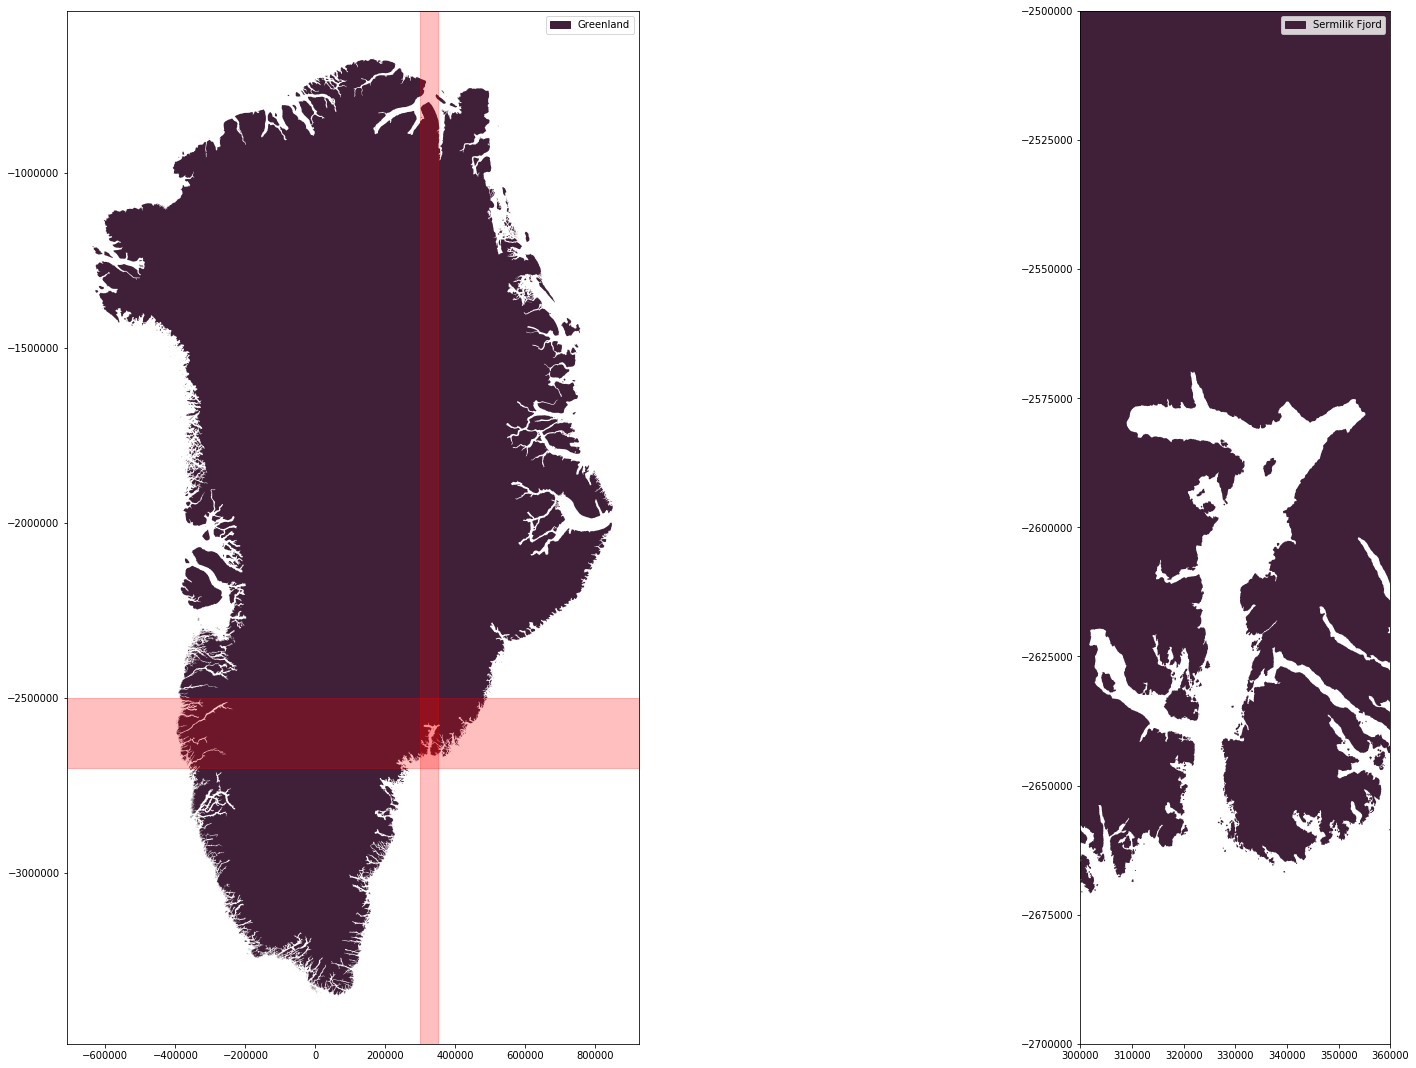

In [151]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(29, 19))

shp_greenland = gpd.read_file('./shps/GreenlandFullRest_3413.shp')
shp_greenland.plot(ax=ax1,figsize=(39,19),facecolor='#402039')
lg = mpl.patches.Patch(color='#402039',label='Greenland')
ax1.legend(handles=[lg])
ax1.axvspan(300000, 350000, color='red', alpha=0.25)
ax1.axhspan(-2700000, -2500000, color='red', alpha=0.25)

shp_greenland.plot(ax=ax2,figsize=(39,19),facecolor='#402039')
ax2.set_xlim(300000, 360000)
ax2.set_ylim(-2700000, -2500000)
lg2 = mpl.patches.Patch(color='#402039',label='Sermilik Fjord')
ax2.legend(handles=[lg2])

plt.show()

## Iceberg size distribution in Sermilik Fjord, SE Greenland

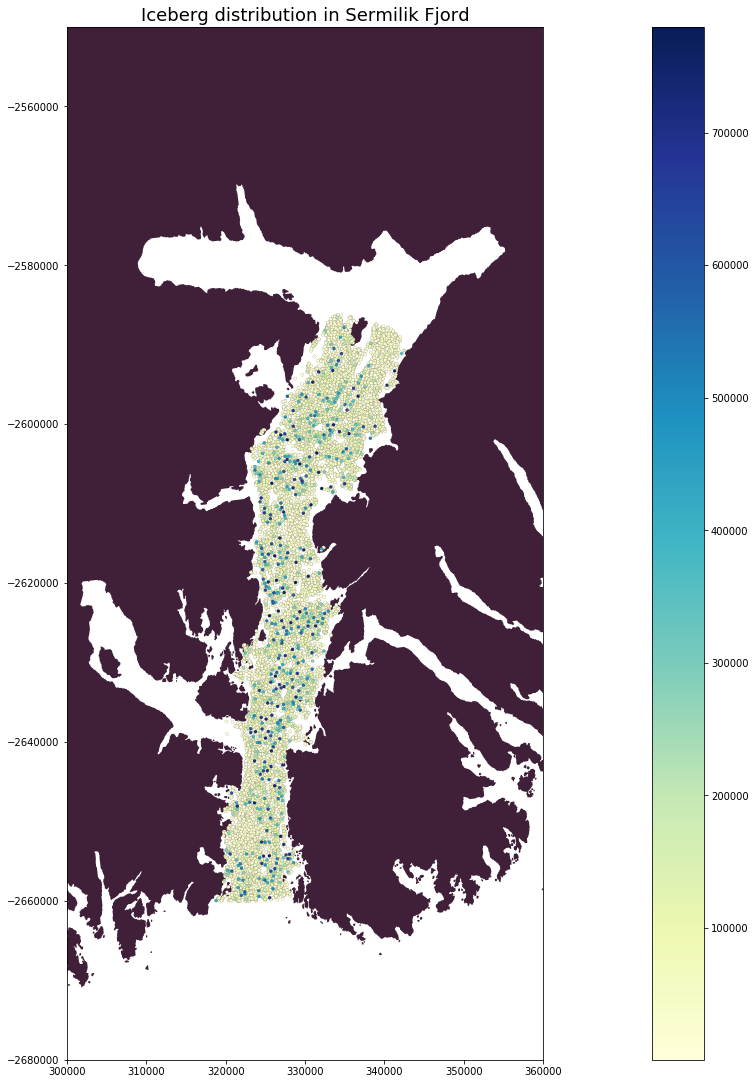

In [148]:
#fig,_ = plt.subplots()
ax2 = shp_greenland.plot(figsize=(39,19),facecolor='#402039')
ax2.set_xlim(300000, 360000)
ax2.set_ylim(-2680000, -2550000)

iceberg_gdf.plot(ax=ax2,column='area_sqm',figsize = (29,19),markersize=10,cmap='YlGnBu',alpha=1,
                       edgecolor='black',lw=0.1)
plt.title('Iceberg distribution in Sermilik Fjord',fontsize=18)
norm1 = mpl.colors.Normalize(vmin=int(iceberg_gdf['area_sqm'].min()),vmax=int(iceberg_gdf['area_sqm'].max()),
                             clip=True)
cbar1 = plt.cm.ScalarMappable(norm=norm1, cmap='YlGnBu')
ax_cbar = fig.colorbar(cbar1, ax=ax2)

#ctx.add_basemap(ax,url=ctx.providers.Stamen.TonerLite)

## Iceberg Frequency Size distribution

Text(0, 0.5, 'Frequency')

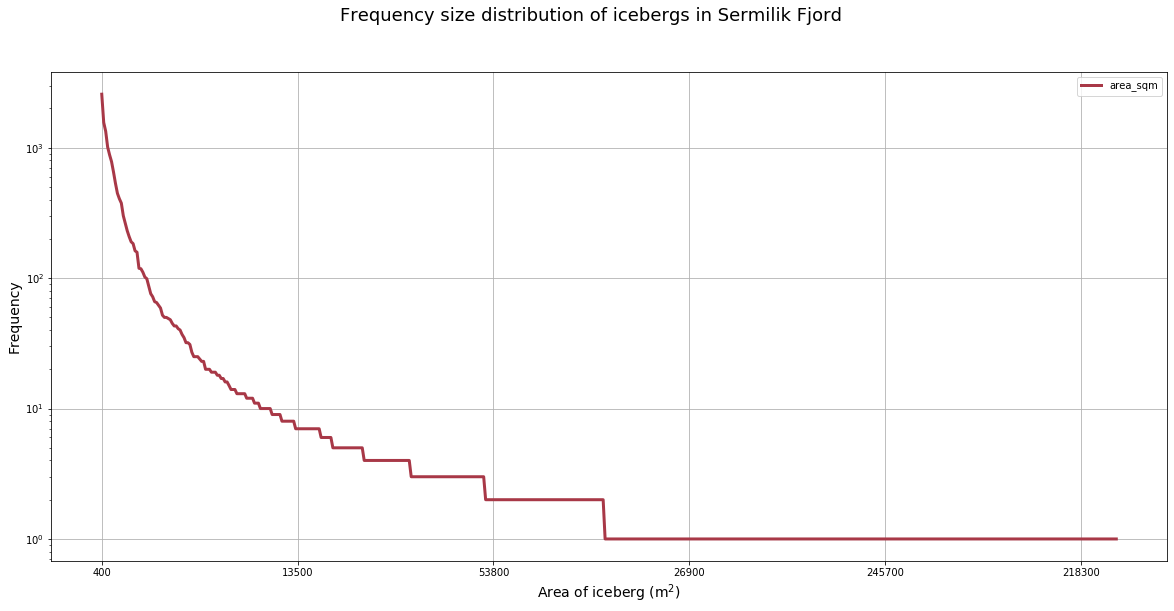

In [91]:
fig, ax = plt.subplots()
fig.suptitle('Frequency size distribution of icebergs in Sermilik Fjord',fontsize=18)
iceberg_gdf = iceberg_gdf.sort_values(by='area_sqm')
(iceberg_gdf['area_sqm'].value_counts()).plot(figsize=(20,9),ax=ax ,kind='line',grid='dotted',
            color='#A83847',lw=3,logy=True,legend=True)
ax.set_xlabel('Area of iceberg (m$^2$)',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)


### Grids representing Sermilik Fjord

##### Loading the shapefiles as geodataframe

In [28]:
#Loading Sermilik shps
shp_Sermilik_gdf = gpd.read_file('./shps/sermilik_extend_100m_buff.shp')
grid_Sermilik_gdf = gpd.read_file('./shps/Sermilik_grid.shp')

##### Converting shapefiles into database tables

__Sermilik Shapefile to Table__

In [29]:
!shp2pgsql -s 3413 -d -I shps/sermilik_extend_100m_buff.shp shp_Sermilik | psql

Field distance is an FTDouble with width 24 and precision 15
Field inner is an FTDouble with width 24 and precision 15
Shapefile type: Polygon
Postgis type: MULTIPOLYGON[2]
SET
SET
              dropgeometrycolumn               
-----------------------------------------------
 public.shp_sermilik.geom effectively removed.
(1 row)

DROP TABLE
BEGIN
CREATE TABLE
ALTER TABLE
                      addgeometrycolumn                       
--------------------------------------------------------------
 public.shp_sermilik.geom SRID:3413 TYPE:MULTIPOLYGON DIMS:2 
(1 row)

INSERT 0 1
CREATE INDEX
COMMIT
ANALYZE


__Gridded Sermilik Shapefile to Table__

In [30]:
!shp2pgsql -s 3413 -d -I shps/Sermilik_grid.shp grid_Sermilik | psql


Field __xmin is an FTDouble with width 21 and precision 5
Field __xmax is an FTDouble with width 21 and precision 5
Field ymin is an FTDouble with width 21 and precision 5
Field ymax is an FTDouble with width 21 and precision 5
Shapefile type: Polygon
Postgis type: MULTIPOLYGON[2]
SET
SET
               dropgeometrycolumn               
------------------------------------------------
 public.grid_sermilik.geom effectively removed.
(1 row)

DROP TABLE
BEGIN
CREATE TABLE
ALTER TABLE
                       addgeometrycolumn                       
---------------------------------------------------------------
 public.grid_sermilik.geom SRID:3413 TYPE:MULTIPOLYGON DIMS:2 
(1 row)

INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSER

In [31]:
%%sql
select * from grid_Sermilik;

 * postgresql://
238 rows affected.


,gid,id,__xmin,__xmax,ymin,ymax,area,geom
0,1,7,332372.11979,334372.11979,-2588144.85392,-2586144.85392,4000000,0106000020550D00000100000001030000000100000005...
1,2,8,334372.11979,336372.11979,-2588144.85392,-2586144.85392,4000000,0106000020550D00000100000001030000000100000005...
2,3,9,336372.11979,338372.11979,-2588144.85392,-2586144.85392,4000000,0106000020550D00000100000001030000000100000005...
3,4,10,338372.11979,340372.11979,-2588144.85392,-2586144.85392,4000000,0106000020550D00000100000001030000000100000005...
4,5,11,340372.11979,342372.11979,-2588144.85392,-2586144.85392,4000000,0106000020550D00000100000001030000000100000005...
...,...,...,...,...,...,...,...,...
233,234,469,320372.11979,322372.11979,-2660144.85392,-2658144.85392,4000000,0106000020550D00000100000001030000000100000005...
234,235,470,322372.11979,324372.11979,-2660144.85392,-2658144.85392,4000000,0106000020550D00000100000001030000000100000005...
235,236,471,324372.11979,326372.11979,-2660144.85392,-2658144.85392,4000000,0106000020550D00000100000001030000000100000005...
236,237,472,326372.11979,328372.11979,-2660144.85392,-2658144.85392,4000000,0106000020550D00000100000001030000000100000005...


In [155]:
#Display gridded Sermilik Fjord table at 2km x 2km
grid_Sermilik_gdf

,id,xmin,xmax,ymin,ymax,Area,geometry
0,7,332372.11979,334372.11979,-2.588145e+06,-2.586145e+06,4000000,"POLYGON ((332372.119793 -2586144.85392, 334372..."
1,8,334372.11979,336372.11979,-2.588145e+06,-2.586145e+06,4000000,"POLYGON ((334372.119793 -2586144.85392, 336372..."
2,9,336372.11979,338372.11979,-2.588145e+06,-2.586145e+06,4000000,"POLYGON ((336372.119793 -2586144.85392, 338372..."
3,10,338372.11979,340372.11979,-2.588145e+06,-2.586145e+06,4000000,"POLYGON ((338372.119793 -2586144.85392, 340372..."
4,11,340372.11979,342372.11979,-2.588145e+06,-2.586145e+06,4000000,"POLYGON ((340372.119793 -2586144.85392, 342372..."
...,...,...,...,...,...,...,...
233,469,320372.11979,322372.11979,-2.660145e+06,-2.658145e+06,4000000,"POLYGON ((320372.119793 -2658144.85392, 322372..."
234,470,322372.11979,324372.11979,-2.660145e+06,-2.658145e+06,4000000,"POLYGON ((322372.119793 -2658144.85392, 324372..."
235,471,324372.11979,326372.11979,-2.660145e+06,-2.658145e+06,4000000,"POLYGON ((324372.119793 -2658144.85392, 326372..."
236,472,326372.11979,328372.11979,-2.660145e+06,-2.658145e+06,4000000,"POLYGON ((326372.119793 -2658144.85392, 328372..."


In [154]:
#Displaying Sermilik Fjord with 2km x 2km grid cell overlapping original Sermilik Fjord shapefile
#ax = shp_Sermilik_gdf.plot(figsize=(20,9))
#grid_Sermilik_gdf.plot(ax=ax,column='Area',figsize=(20,9),facecolor='none',edgecolor='black')

## Percentage Ice Cover

##### Overlap display of iceberg data with gridded Sermilik geodataframe


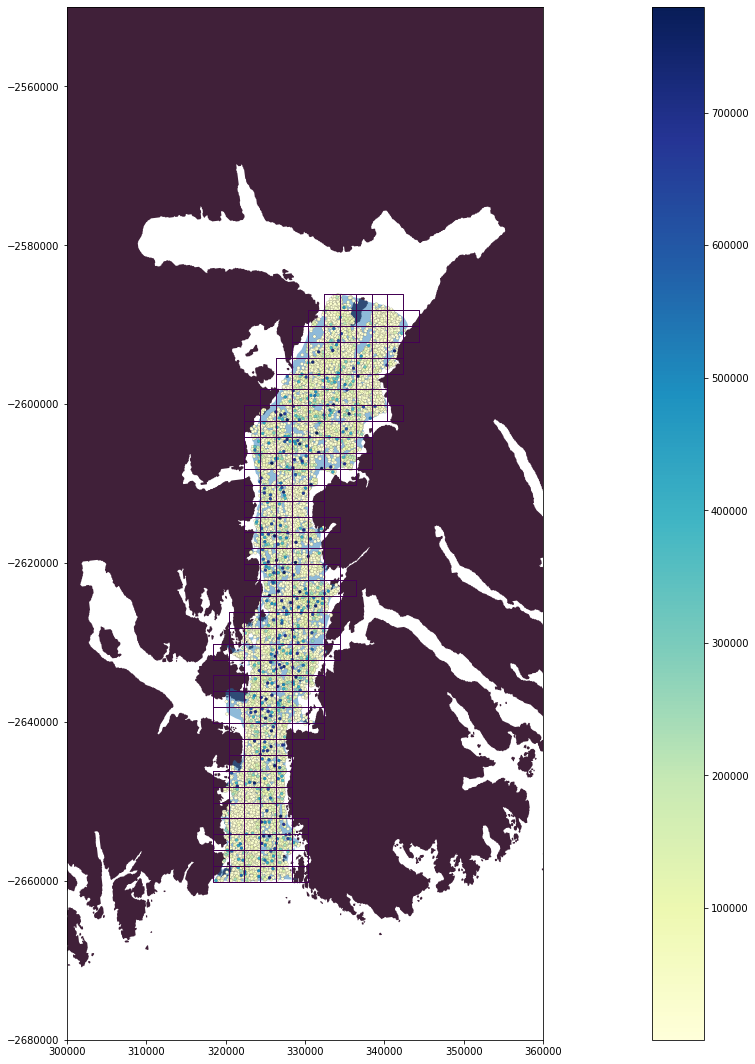

In [130]:
ax2 = shp_greenland.plot(figsize=(39,19),facecolor='#402039')
ax2.set_xlim(300000, 360000)
ax2.set_ylim(-2680000, -2550000)

shp_Sermilik_gdf.plot(ax=ax2,figsize=(20,19),alpha=0.5)
iceberg_gdf.plot(ax=ax2,column='area_sqm',figsize = (29,19),markersize=10,cmap='YlGnBu',alpha=1,
                       edgecolor='black',lw=0.1)
grid_Sermilik_gdf.plot(ax=ax2,column='Area',figsize=(29,19),facecolor='none',edgecolor='black')
norm1 = mpl.colors.Normalize(vmin=int(iceberg_gdf['area_sqm'].min()),vmax=int(iceberg_gdf['area_sqm'].max()),
                             clip=True)
cbar1 = plt.cm.ScalarMappable(norm=norm1, cmap='YlGnBu')
ax_cbar = fig.colorbar(cbar1, ax=ax2)


In [36]:
%%sql
select * from grid_Sermilik;

 * postgresql://
238 rows affected.


,gid,id,__xmin,__xmax,ymin,ymax,area,geom
0,1,7,332372.11979,334372.11979,-2588144.85392,-2586144.85392,4000000,0106000020550D00000100000001030000000100000005...
1,2,8,334372.11979,336372.11979,-2588144.85392,-2586144.85392,4000000,0106000020550D00000100000001030000000100000005...
2,3,9,336372.11979,338372.11979,-2588144.85392,-2586144.85392,4000000,0106000020550D00000100000001030000000100000005...
3,4,10,338372.11979,340372.11979,-2588144.85392,-2586144.85392,4000000,0106000020550D00000100000001030000000100000005...
4,5,11,340372.11979,342372.11979,-2588144.85392,-2586144.85392,4000000,0106000020550D00000100000001030000000100000005...
...,...,...,...,...,...,...,...,...
233,234,469,320372.11979,322372.11979,-2660144.85392,-2658144.85392,4000000,0106000020550D00000100000001030000000100000005...
234,235,470,322372.11979,324372.11979,-2660144.85392,-2658144.85392,4000000,0106000020550D00000100000001030000000100000005...
235,236,471,324372.11979,326372.11979,-2660144.85392,-2658144.85392,4000000,0106000020550D00000100000001030000000100000005...
236,237,472,326372.11979,328372.11979,-2660144.85392,-2658144.85392,4000000,0106000020550D00000100000001030000000100000005...


In [37]:
%%sql
select * from iceberg_dist;

 * postgresql://
15483 rows affected.


,id,area_sqm,x,y,totalarea,geom_2
0,1,1100,334165.16864305234,-2586242.8126422013,None,0101000020550D0000AAC3B0AC54651441DFA8046841BB...
1,2,1000,334102.532279416,-2586287.176278565,None,0101000020550D0000F0DA0D215A641441C84B909657BB...
2,3,1100,334526.07773396146,-2586311.903551292,None,0101000020550D0000D97D994FF86A14419991A7F363BB...
3,4,400,334296.532279416,-2586374.176278565,None,0101000020550D0000F0DA0D2162671441C84B901683BB...
4,5,500,333993.532279416,-2586383.176278565,None,0101000020550D0000F0DA0D21A6621441C84B909687BB...
...,...,...,...,...,...,...
15478,15479,400,323846.532279416,-2659994.176278565,None,0101000020550D0000F0DA0D211AC41341C84B90164D4B...
15479,15480,1600,322935.282279416,-2660027.926278565,None,0101000020550D0000F0DA0D21DDB51341C84B90F65D4B...
15480,15481,2500,321834.732279416,-2660056.3762785653,None,0101000020550D0000BDA7DAEDAAA4134162E529306C4B...
15481,15482,700,321598.6751365588,-2660054.890564279,None,0101000020550D000082FF56B3FAA01341A302FE716B4B...


In [39]:
%%sql
SELECT ST_SRID(geom_2) FROM iceberg_dist;--select * from grid_Sermilik;

 * postgresql://
15483 rows affected.


,st_srid
0,3413
1,3413
2,3413
3,3413
4,3413
...,...
15478,3413
15479,3413
15480,3413
15481,3413


__New table that captures the point table intersect with grid polygon table : "overlap_pt_grid"__

In [40]:
%%sql
DROP TABLE IF EXISTS overlap_pt_grid;
CREATE TABLE overlap_pt_grid AS 
SELECT grid_Sermilik.*,iceberg_dist.x, iceberg_dist.y, iceberg_dist.area_sqm, iceberg_dist.geom_2,
ST_Intersection(iceberg_dist.geom_2,grid_Sermilik.geom)
FROM grid_Sermilik, iceberg_dist WHERE ST_Intersects(iceberg_dist.geom_2, grid_Sermilik.geom);



 * postgresql://
Done.
15483 rows affected.


""


In [41]:
%%sql
select * from overlap_pt_grid where id=124;

 * postgresql://
67 rows affected.


,gid,id,__xmin,__xmax,ymin,ymax,area,geom,x,y,area_sqm,geom_2,st_intersection
0,74,124,332372.11979,334372.11979,-2606144.85392,-2604144.85392,4000000,0106000020550D00000100000001030000000100000005...,334001.3142957648,-2604372.527777203,36700,0101000020550D0000BCBFD641C562144111348E43AADE...,0101000020550D0000BCBFD641C562144111348E43AADE...
1,74,124,332372.11979,334372.11979,-2606144.85392,-2604144.85392,4000000,0106000020550D00000100000001030000000100000005...,333337.532279416,-2604163.176278565,2500,0101000020550D0000F0DA0D2166581441C84B909641DE...,0101000020550D0000F0DA0D2166581441C84B909641DE...
2,74,124,332372.11979,334372.11979,-2606144.85392,-2604144.85392,4000000,0106000020550D00000100000001030000000100000005...,333591.38190347614,-2604243.6875567604,13300,0101000020550D000071B411875D5C144124DC01D869DE...,0101000020550D000071B411875D5C144124DC01D869DE...
3,74,124,332372.11979,334372.11979,-2606144.85392,-2604144.85392,4000000,0106000020550D00000100000001030000000100000005...,333406.532279416,-2604184.176278565,400,0101000020550D0000F0DA0D217A591441C84B90164CDE...,0101000020550D0000F0DA0D217A591441C84B90164CDE...
4,74,124,332372.11979,334372.11979,-2606144.85392,-2604144.85392,4000000,0106000020550D00000100000001030000000100000005...,333448.1989460827,-2604234.7318341206,900,0101000020550D00009B85B8CB205A14418FBDAC5D65DE...,0101000020550D00009B85B8CB205A14418FBDAC5D65DE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,74,124,332372.11979,334372.11979,-2606144.85392,-2604144.85392,4000000,0106000020550D00000100000001030000000100000005...,333107.532279416,-2605861.176278565,500,0101000020550D0000F0DA0D21CE541441C84B909692E1...,0101000020550D0000F0DA0D21CE541441C84B909692E1...
63,74,124,332372.11979,334372.11979,-2606144.85392,-2604144.85392,4000000,0106000020550D00000100000001030000000100000005...,332461.5794492273,-2606017.242316301,21200,0101000020550D000064235B51B64A14417638049FE0E1...,0101000020550D000064235B51B64A14417638049FE0E1...
64,74,124,332372.11979,334372.11979,-2606144.85392,-2604144.85392,4000000,0106000020550D00000100000001030000000100000005...,333196.532279416,-2605984.176278565,400,0101000020550D0000F0DA0D2132561441C84B9016D0E1...,0101000020550D0000F0DA0D2132561441C84B9016D0E1...
65,74,124,332372.11979,334372.11979,-2606144.85392,-2604144.85392,4000000,0106000020550D00000100000001030000000100000005...,333203.932279416,-2606053.576278565,2500,0101000020550D00008A74A7BA4F561441FB7EC3C9F2E1...,0101000020550D00008A74A7BA4F561441FB7EC3C9F2E1...


__Table with sum of all points that overlap/within a grid cell: "overlap_pt_grid_sum"__

In [42]:
%%sql
DROP TABLE IF EXISTS overlap_pt_grid_sum;
CREATE TABLE overlap_pt_grid_sum AS 
select overlap_pt_grid.id, overlap_pt_grid.geom, overlap_pt_grid.area,
    overlap_pt_grid.__xmin,overlap_pt_grid.__xmax,overlap_pt_grid.ymin,overlap_pt_grid.ymax, 
    sum(overlap_pt_grid.area_sqm)

from overlap_pt_grid 
group by overlap_pt_grid.__xmin,overlap_pt_grid.__xmax,overlap_pt_grid.ymin,overlap_pt_grid.ymax,
overlap_pt_grid.id, overlap_pt_grid.geom, overlap_pt_grid.area;

 * postgresql://
Done.
219 rows affected.


""


In [43]:
%%sql
select * from overlap_pt_grid_sum;

 * postgresql://
219 rows affected.


,id,geom,area,__xmin,__xmax,ymin,ymax,sum
0,74,0106000020550D00000100000001030000000100000005...,4000000,336372.11979,338372.11979,-2598144.85392,-2596144.85392,330500
1,75,0106000020550D00000100000001030000000100000005...,4000000,338372.11979,340372.11979,-2598144.85392,-2596144.85392,69900
2,250,0106000020550D00000100000001030000000100000005...,4000000,324372.11979,326372.11979,-2626144.85392,-2624144.85392,229900
3,124,0106000020550D00000100000001030000000100000005...,4000000,332372.11979,334372.11979,-2606144.85392,-2604144.85392,147100
4,394,0106000020550D00000100000001030000000100000005...,4000000,326372.11979,328372.11979,-2648144.85392,-2646144.85392,259500
...,...,...,...,...,...,...,...,...
214,123,0106000020550D00000100000001030000000100000005...,4000000,330372.11979,332372.11979,-2606144.85392,-2604144.85392,367100
215,86,0106000020550D00000100000001030000000100000005...,4000000,334372.11979,336372.11979,-2600144.85392,-2598144.85392,312500
216,19,0106000020550D00000100000001030000000100000005...,4000000,330372.11979,332372.11979,-2590144.85392,-2588144.85392,42300
217,241,0106000020550D00000100000001030000000100000005...,4000000,332372.11979,334372.11979,-2624144.85392,-2622144.85392,179300


In [44]:
%%sql
select *,(sum/area)*100 as percent from overlap_pt_grid_sum;

 * postgresql://
219 rows affected.


,id,geom,area,__xmin,__xmax,ymin,ymax,sum,percent
0,74,0106000020550D00000100000001030000000100000005...,4000000,336372.11979,338372.11979,-2598144.85392,-2596144.85392,330500,8.26250000000000000000
1,75,0106000020550D00000100000001030000000100000005...,4000000,338372.11979,340372.11979,-2598144.85392,-2596144.85392,69900,1.74750000000000000000
2,250,0106000020550D00000100000001030000000100000005...,4000000,324372.11979,326372.11979,-2626144.85392,-2624144.85392,229900,5.74750000000000000000
3,124,0106000020550D00000100000001030000000100000005...,4000000,332372.11979,334372.11979,-2606144.85392,-2604144.85392,147100,3.67750000000000000000
4,394,0106000020550D00000100000001030000000100000005...,4000000,326372.11979,328372.11979,-2648144.85392,-2646144.85392,259500,6.48750000000000000000
...,...,...,...,...,...,...,...,...,...
214,123,0106000020550D00000100000001030000000100000005...,4000000,330372.11979,332372.11979,-2606144.85392,-2604144.85392,367100,9.17750000000000000000
215,86,0106000020550D00000100000001030000000100000005...,4000000,334372.11979,336372.11979,-2600144.85392,-2598144.85392,312500,7.81250000000000000000
216,19,0106000020550D00000100000001030000000100000005...,4000000,330372.11979,332372.11979,-2590144.85392,-2588144.85392,42300,1.05750000000000000000
217,241,0106000020550D00000100000001030000000100000005...,4000000,332372.11979,334372.11979,-2624144.85392,-2622144.85392,179300,4.48250000000000000000


In [45]:
%%sql
select * from overlap_pt_grid_sum;

 * postgresql://
219 rows affected.


,id,geom,area,__xmin,__xmax,ymin,ymax,sum
0,74,0106000020550D00000100000001030000000100000005...,4000000,336372.11979,338372.11979,-2598144.85392,-2596144.85392,330500
1,75,0106000020550D00000100000001030000000100000005...,4000000,338372.11979,340372.11979,-2598144.85392,-2596144.85392,69900
2,250,0106000020550D00000100000001030000000100000005...,4000000,324372.11979,326372.11979,-2626144.85392,-2624144.85392,229900
3,124,0106000020550D00000100000001030000000100000005...,4000000,332372.11979,334372.11979,-2606144.85392,-2604144.85392,147100
4,394,0106000020550D00000100000001030000000100000005...,4000000,326372.11979,328372.11979,-2648144.85392,-2646144.85392,259500
...,...,...,...,...,...,...,...,...
214,123,0106000020550D00000100000001030000000100000005...,4000000,330372.11979,332372.11979,-2606144.85392,-2604144.85392,367100
215,86,0106000020550D00000100000001030000000100000005...,4000000,334372.11979,336372.11979,-2600144.85392,-2598144.85392,312500
216,19,0106000020550D00000100000001030000000100000005...,4000000,330372.11979,332372.11979,-2590144.85392,-2588144.85392,42300
217,241,0106000020550D00000100000001030000000100000005...,4000000,332372.11979,334372.11979,-2624144.85392,-2622144.85392,179300


__Ice cover percentage per grid cell table: "overlap_pt_grid_percent"__ 

In [46]:
%%sql
DROP TABLE IF EXISTS overlap_pt_grid_percent;
CREATE TABLE overlap_pt_grid_percent AS 
select *,(sum/area)*100 as percent 
from overlap_pt_grid_sum;

 * postgresql://
Done.
219 rows affected.


""


In [47]:
%%sql
select * from overlap_pt_grid_percent;

 * postgresql://
219 rows affected.


,id,geom,area,__xmin,__xmax,ymin,ymax,sum,percent
0,74,0106000020550D00000100000001030000000100000005...,4000000,336372.11979,338372.11979,-2598144.85392,-2596144.85392,330500,8.26250000000000000000
1,75,0106000020550D00000100000001030000000100000005...,4000000,338372.11979,340372.11979,-2598144.85392,-2596144.85392,69900,1.74750000000000000000
2,250,0106000020550D00000100000001030000000100000005...,4000000,324372.11979,326372.11979,-2626144.85392,-2624144.85392,229900,5.74750000000000000000
3,124,0106000020550D00000100000001030000000100000005...,4000000,332372.11979,334372.11979,-2606144.85392,-2604144.85392,147100,3.67750000000000000000
4,394,0106000020550D00000100000001030000000100000005...,4000000,326372.11979,328372.11979,-2648144.85392,-2646144.85392,259500,6.48750000000000000000
...,...,...,...,...,...,...,...,...,...
214,123,0106000020550D00000100000001030000000100000005...,4000000,330372.11979,332372.11979,-2606144.85392,-2604144.85392,367100,9.17750000000000000000
215,86,0106000020550D00000100000001030000000100000005...,4000000,334372.11979,336372.11979,-2600144.85392,-2598144.85392,312500,7.81250000000000000000
216,19,0106000020550D00000100000001030000000100000005...,4000000,330372.11979,332372.11979,-2590144.85392,-2588144.85392,42300,1.05750000000000000000
217,241,0106000020550D00000100000001030000000100000005...,4000000,332372.11979,334372.11979,-2624144.85392,-2622144.85392,179300,4.48250000000000000000


In [48]:
%%sql
percent_df << 
SELECT *
FROM overlap_pt_grid_percent;

 * postgresql://
219 rows affected.
Returning data to local variable percent_df


In [49]:
percent_gdf = spdb_geodataframe_postgis(percent_df,geom_col='geom')

In [50]:
percent_gdf

,id,geom,area,__xmin,__xmax,ymin,ymax,sum,percent
0,74,"(POLYGON ((336372.119793 -2596144.85392, 33837...",4000000,336372.11979,338372.11979,-2598144.85392,-2596144.85392,330500,8.26250000000000000000
1,75,"(POLYGON ((338372.119793 -2596144.85392, 34037...",4000000,338372.11979,340372.11979,-2598144.85392,-2596144.85392,69900,1.74750000000000000000
2,250,"(POLYGON ((324372.119793 -2624144.85392, 32637...",4000000,324372.11979,326372.11979,-2626144.85392,-2624144.85392,229900,5.74750000000000000000
3,124,"(POLYGON ((332372.119793 -2604144.85392, 33437...",4000000,332372.11979,334372.11979,-2606144.85392,-2604144.85392,147100,3.67750000000000000000
4,394,"(POLYGON ((326372.119793 -2646144.85392, 32837...",4000000,326372.11979,328372.11979,-2648144.85392,-2646144.85392,259500,6.48750000000000000000
...,...,...,...,...,...,...,...,...,...
214,123,"(POLYGON ((330372.119793 -2604144.85392, 33237...",4000000,330372.11979,332372.11979,-2606144.85392,-2604144.85392,367100,9.17750000000000000000
215,86,"(POLYGON ((334372.119793 -2598144.85392, 33637...",4000000,334372.11979,336372.11979,-2600144.85392,-2598144.85392,312500,7.81250000000000000000
216,19,"(POLYGON ((330372.119793 -2588144.85392, 33237...",4000000,330372.11979,332372.11979,-2590144.85392,-2588144.85392,42300,1.05750000000000000000
217,241,"(POLYGON ((332372.119793 -2622144.85392, 33437...",4000000,332372.11979,334372.11979,-2624144.85392,-2622144.85392,179300,4.48250000000000000000


#### Iceberg cover percentage per grid cell in Sermilik Fjord, SE Greenland ####

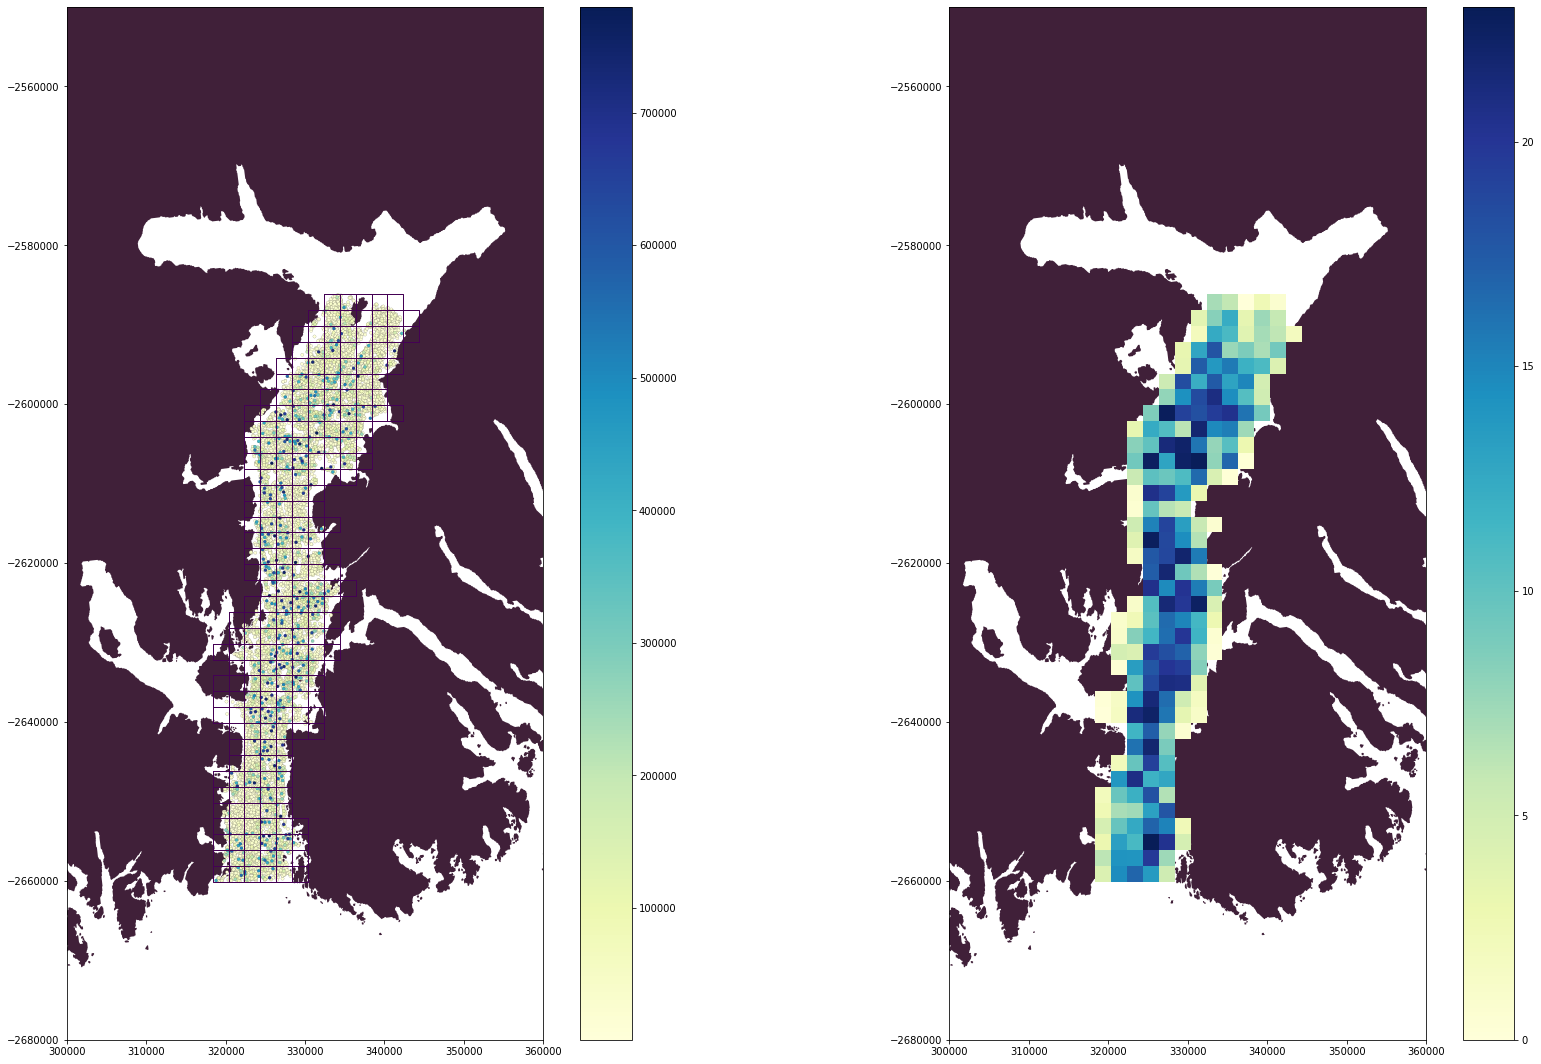

In [136]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(29, 19))
#Iceberg points overlap 2km x 2km grid cells
shp_greenland.plot(ax=ax1,figsize=(29,19),facecolor='#402039')
ax1.set_xlim(300000, 360000)
ax1.set_ylim(-2680000, -2550000)
iceberg_gdf.plot(ax=ax1,column='area_sqm',figsize = (29,19),markersize=10,cmap='YlGnBu',alpha=1,edgecolor='black',lw=0.1)
norm1 = mpl.colors.Normalize(vmin=int(iceberg_gdf['area_sqm'].min()),vmax=int(iceberg_gdf['area_sqm'].max()),clip=True)
cbar1 = plt.cm.ScalarMappable(norm=norm1, cmap='YlGnBu')
ax_cbar = fig.colorbar(cbar1, ax=ax1)
grid_Sermilik_gdf.plot(ax=ax1,column='Area',figsize=(29,19),facecolor='none',edgecolor='black')

#Gridded map with colorbar plot
shp_greenland.plot(ax=ax2,figsize=(29,19),facecolor='#402039')
ax2.set_xlim(300000, 360000)
ax2.set_ylim(-2680000, -2550000)
percent_gdf.plot(ax=ax2,column='percent',figsize = (29,19),markersize=10,cmap='YlGnBu',alpha=1,legend=False)
norm = mpl.colors.Normalize(vmin=int(percent_gdf['percent'].min()),vmax=int(percent_gdf['percent'].max()),clip=True)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='YlGnBu')
ax_cbar = fig.colorbar(cbar, ax=ax2)
#ctx.add_basemap(ax2,url=ctx.providers.Stamen.TonerLite)

# References

Copernicus Sentinel data [2016]. Retrieved from ASF DAAC [2019], processed by ESA
